In [310]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import keras
from keras.datasets import cifar10

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [311]:
trainset  = CIFAR10(root='./data', train=True , download=True)
testset   = CIFAR10(root='./data', train=False, download=True)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
Xtr  = trainset.data
Xte  = testset.data
Ytr  = np.array(trainset.targets)
Yte  = np.array(testset.targets)

Files already downloaded and verified
Files already downloaded and verified


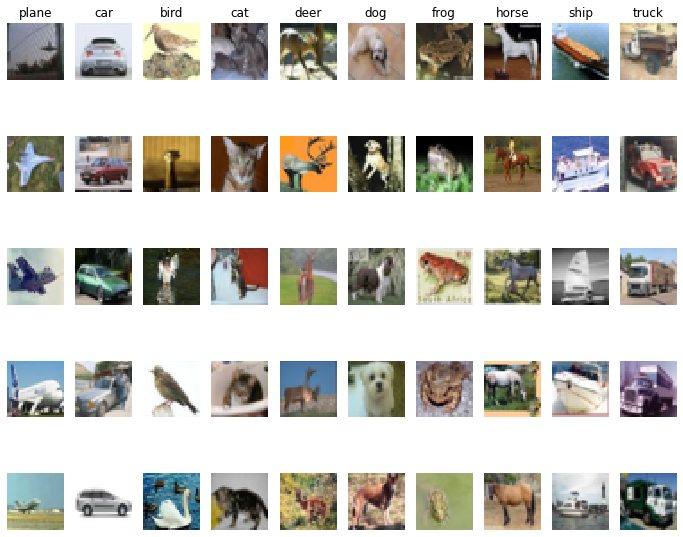

In [312]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [313]:
# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

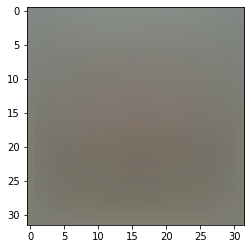

In [314]:
mean_image = np.mean(Xtr_rows, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [315]:
Xtr_rows = Xtr_rows.astype('float64')
Xtr_rows -= mean_image 

Xte_rows = Xte_rows.astype('float64')
Xte_rows -= mean_image

In [316]:
one_hot_labels = np.zeros((Xtr_rows.shape[0], 10))

for i in range(Xtr_rows.shape[0]):
    one_hot_labels[i, Ytr[i]] = 1

instances = Xtr_rows.shape[0]
attributes = Xtr_rows.shape[1]

hidden_nodes1 = 1000
hidden_nodes2 = 100

output_labels = 10


one = torch.nn.Linear(attributes,hidden_nodes1)
wh1 = torch.nn.init.xavier_uniform_(torch.empty(attributes, hidden_nodes1)).detach().numpy()
bh1 = torch.nn.init.zeros_(one.bias).detach().numpy()

two = torch.nn.Linear(hidden_nodes1,hidden_nodes2)
wh2 = torch.nn.init.xavier_uniform_(torch.empty(hidden_nodes1, hidden_nodes2)).detach().numpy()
bh2 = torch.nn.init.zeros_(two.bias).detach().numpy()

output = torch.nn.Linear(hidden_nodes2,output_labels)
wo = torch.nn.init.xavier_uniform_(torch.empty(hidden_nodes2, output_labels)).detach().numpy()
bo = torch.nn.init.zeros_(output.bias).detach().numpy()


lr = 0.00001

error_cost = []    

       

In [317]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

In [318]:
for epoch in range(10):
    
    ######### feedforward

    # Phase 1

    zh1 = np.dot(Xtr_rows, wh1) + bh1
    ah1 = sigmoid(zh1)

    # Phase 2
    
    zh2 = np.dot(ah1, wh2) + bh2
    ah2 = sigmoid(zh2)

    
    # Phase 3
    zo = np.dot(ah2, wo) + bo
    ao = softmax(zo)


    ########## Back Propagation

    ########## Phase 1
    dcost_dzo = ao - one_hot_labels
    dzo_dwo = ah2

    dwo = np.dot(dzo_dwo.T, dcost_dzo)
    dbo = dcost_dzo

    ########## Phases 2
    dzo_dah2 = wo
    dcost_dah2 = np.dot(dcost_dzo, dzo_dah2.T)

    dah2_dzh2 = sigmoid_der(zh2)
    dzh2_dwh2 = ah1

    dcost_dzh2 = dah2_dzh2 * dcost_dah2

    dwh2 = np.dot(dzh2_dwh2.T, dcost_dzh2)
    dbh2 = dcost_dzh2

    ########## Phases 3
    dzh2_dah1 = wh2
    dcost_dah1 = np.dot(dcost_dzh2, dzh2_dah1.T)

    dah1_dzh1 = sigmoid_der(zh1)
    dzh1_dwh1 = Xtr_rows

    dcost_dzh1 = dah1_dzh1 * dcost_dah1

    dwh1 = np.dot(dzh1_dwh1.T, dcost_dzh1)
    dbh1 = dah1_dzh1 * dcost_dah1

    # Update Weights
    wh1 -= lr * dwh1
    wh2 -= lr * dwh2
    wo -=  lr * dwo

    # Update Bias
    bh1 -= lr * dbh1.sum(axis=0)
    bh2 -= lr * dbh2.sum(axis=0)
    bo -=  lr* dbo.sum(axis=0)

    loss = np.sum(-one_hot_labels * np.log(ao))
    error_cost.append(loss)
            


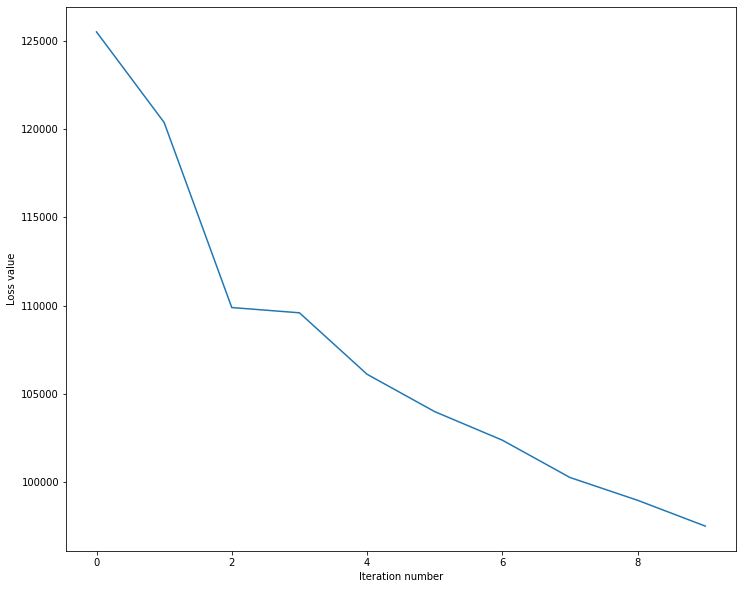

In [319]:
plt.plot(error_cost)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Train data report



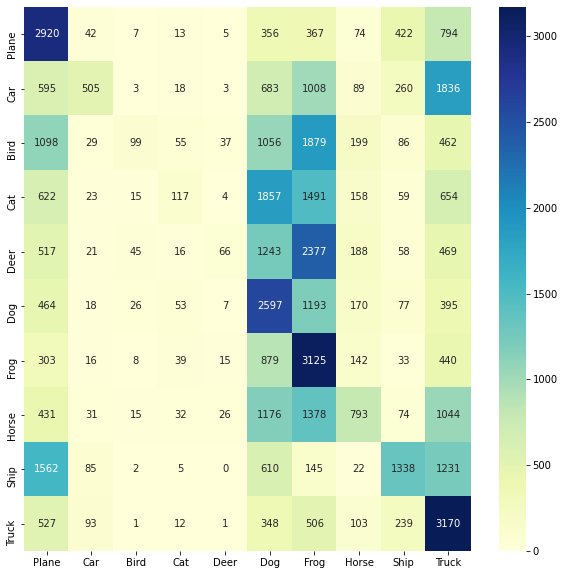

Accurecy
--------------------------
0.2946

Classification report
--------------------------
              precision    recall  f1-score   support

       Plane       0.32      0.58      0.42      5000
         Car       0.59      0.10      0.17      5000
        Bird       0.45      0.02      0.04      5000
         Cat       0.33      0.02      0.04      5000
        Deer       0.40      0.01      0.03      5000
         Dog       0.24      0.52      0.33      5000
        Frog       0.23      0.62      0.34      5000
       Horse       0.41      0.16      0.23      5000
        Ship       0.51      0.27      0.35      5000
       Truck       0.30      0.63      0.41      5000

    accuracy                           0.29     50000
   macro avg       0.38      0.29      0.24     50000
weighted avg       0.38      0.29      0.24     50000



In [320]:
print("Train data report")
print("===================================")
print()

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

z_train_data  = ao

temp_z_train_data = np.zeros((z_train_data.shape[0]))

index = 0
for r in z_train_data:
    temp_z_train_data[index] = r.argmax()
    index = index + 1
    
z_train_data = temp_z_train_data 



predict_train =  z_train_data

# confusion matrix

cm = confusion_matrix(Ytr, predict_train)

array = cm.tolist()
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,10))
sns.heatmap(df_cm, cmap="YlGnBu",annot=True, fmt="d")

plt.show()

print("Accurecy")
print("--------------------------")
print(accuracy_score(Ytr, predict_train))
print()

print("Classification report")
print("--------------------------")
print(classification_report(Ytr, predict_train, target_names=class_names))

Test data report



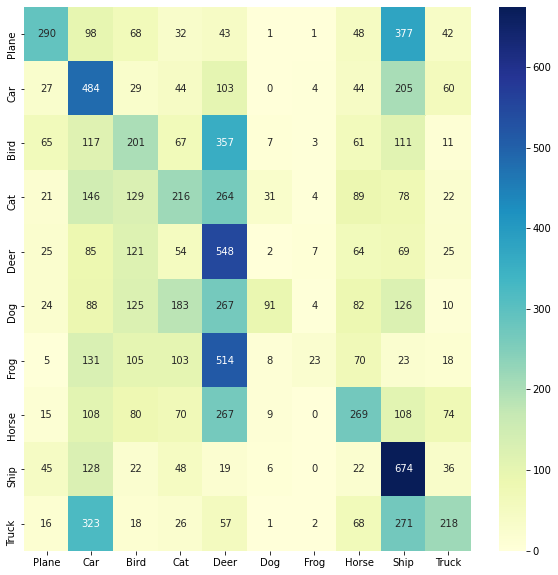

Accurecy
--------------------------
0.3014

Classification report
--------------------------
              precision    recall  f1-score   support

       Plane       0.54      0.29      0.38      1000
         Car       0.28      0.48      0.36      1000
        Bird       0.22      0.20      0.21      1000
         Cat       0.26      0.22      0.23      1000
        Deer       0.22      0.55      0.32      1000
         Dog       0.58      0.09      0.16      1000
        Frog       0.48      0.02      0.04      1000
       Horse       0.33      0.27      0.30      1000
        Ship       0.33      0.67      0.44      1000
       Truck       0.42      0.22      0.29      1000

    accuracy                           0.30     10000
   macro avg       0.37      0.30      0.27     10000
weighted avg       0.37      0.30      0.27     10000



In [321]:
test_zh1 = np.dot(Xte_rows, wh1) + bh1
test_ah1 = sigmoid(test_zh1)

# Phase 2

test_zh2 = np.dot(test_ah1, wh2) + bh2
test_ah2 = sigmoid(test_zh2)

# Phase 3
test_zo = np.dot(test_ah2, wo) + bo
test_ao = softmax(test_zo)


print("Test data report")
print("===================================")
print()

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

z_test_data = test_ao

temp_z_test_data = np.zeros((z_test_data.shape[0]))

index = 0
for r in z_test_data:
    temp_z_test_data[index] = r.argmax()
    index = index + 1

z_test_data = temp_z_test_data 



predict_test =  z_test_data

# confusion matrix

cm = confusion_matrix(Yte, predict_test)

array = cm.tolist()
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,10))
sns.heatmap(df_cm, cmap="YlGnBu",annot=True, fmt="d")

plt.show()

print("Accurecy")
print("--------------------------")
print(accuracy_score(Yte, predict_test))
print()

print("Classification report")
print("--------------------------")
print(classification_report(Yte, predict_test, target_names=class_names))



